# DL Module : Project 2 ( Sarcasm Detection)

# Part II: RNN

## DOMAIN: Social Media Analytics

### CONTEXT: 
Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets arerepliestoother tweets and detecting sarcasm in these require the availability of contextual tweets. In this hands-on project,
the goal is to build a model to detect whether a sentence is sarcastic or not, using Bidirectional LSTMs.

### DATASET DESCRIPTION:
The dataset is collected from two news websites, theonion.com and huffingtonpost.com. This newdataset hasthefollowing advantages over the existing Twitter datasets:

Since news headlines are written by professionals in a formal manner, there are no spelling mistakes andinformal
usage. This reduces the sparsity and increases the chance of finding pre-trained embeddings. Furthermore, sincethe sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much lessnoiseascompared to Twitter datasets.

Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This wouldhelpusinteasing apart the real sarcastic elements,
- Content: Each record consists of three attributes:
- is_sarcastic: 1 if the record is sarcastic otherwise 0
- headline: the headline of the news article
- article_link: link to the original news article. Useful in collecting supplementary data
- Reference: https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection

### PROJECT OBJECTIVE: 
Build a sequential NLP classifier which can use input text parameters to determinethecustomer sentiments.

### STEPS AND TASKS:

### Importing all required libraries

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
import os
import re
import tensorflow 
import keras

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout, Flatten
from keras.layers import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from functools import partial
from keras.layers import BatchNormalization
from keras.optimizers import Adam
tensorflow.__version__

'2.12.0'

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Importing Data

In [5]:
df = pd.read_json('/content/gdrive/MyDrive/Sarcasm_Headlines_Dataset.json', lines = True)

In [6]:
df

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
26704,https://www.huffingtonpost.com/entry/american-...,american politics in moral free-fall,0
26705,https://www.huffingtonpost.com/entry/americas-...,america's best 20 hikes,0
26706,https://www.huffingtonpost.com/entry/reparatio...,reparations and obama,0
26707,https://www.huffingtonpost.com/entry/israeli-b...,israeli ban targeting boycott supporters raise...,0


### Analyzing our Data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


- We can see no null entries in our dataset

In [8]:
df.shape

(26709, 3)

### Visualizing data

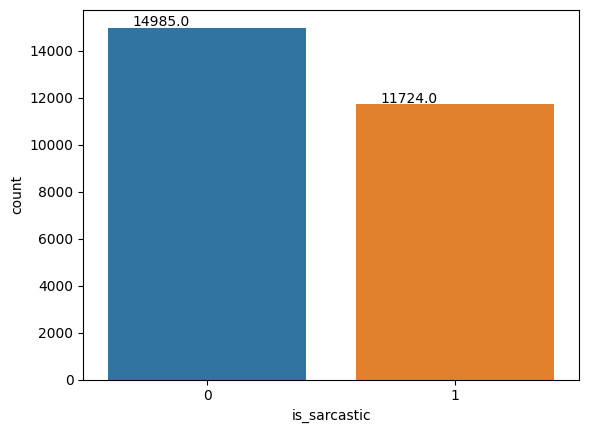

In [11]:
# Lets visualize the distribution of our target class
ax = sns.countplot(data = df, x='is_sarcastic')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

- We can observe some imbalance in our target class
- Data for sarcastic class is less as compared to non-sarcastic class, 44:56 ratio !

### Retain relevant columns

In [12]:
# For developing our NLP model we can see that only the headlines and the target labels are required
# So, we'll drop the 'article_link' feature
df = df.drop('article_link', axis = 1)
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


### Get length for each sentence

In [13]:
df['length'] = df['headline'].apply(lambda x: len(x))
df.head()

,headline,is_sarcastic,length
0,former versace store clerk sues over secret 'b...,0,78
1,the 'roseanne' revival catches up to our thorn...,0,84
2,mom starting to fear son's web series closest ...,1,79
3,"boehner just wants wife to listen, not come up...",1,84
4,j.k. rowling wishes snape happy birthday in th...,0,64


In [20]:
df['length'].describe()

count    26709.000000
mean        60.910592
std         19.184470
min          7.000000
25%         48.000000
50%         61.000000
75%         73.000000
max        254.000000
Name: length, dtype: float64

### Parameters:

In [21]:
max_features = 10000
maxlen = 25
embedding_size = 50

### Get indices for words (Tokenization)

In [22]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(df['headline']))
X = tokenizer.texts_to_sequences(df['headline'])

print("Number of Samples:", len(X))       
print(X[0]) 

Number of Samples: 26709
[307, 678, 3336, 2297, 47, 381, 2575, 5, 2576, 8433]


### Padding all the headlines

In [23]:
X = pad_sequences(X, maxlen = maxlen)     
y = np.asarray(df['is_sarcastic'])

print('Number of sentences and labels: ', len(y), ',', len(X), '\n')
print(X[0], '\n') 
print(y[0])

Number of sentences and labels:  26709 , 26709 

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  307  678 3336 2297   47  381 2575    5 2576 8433] 

0


In [24]:
X.shape

(26709, 25)

### Get vocabulary size

In [25]:
num_words  = len(tokenizer.word_index) + 1
print(num_words)

29657


### Weight Matrix using Glove Embedding

In [26]:
# We are making use of glove.6B.50d.txt file for embedding

EMBEDDING_FILE = '/content/gdrive/MyDrive/glove.6B.50d.txt'
embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

In [27]:
#  create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words , 50))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [28]:
print (len(embeddings))

400000


In [29]:
print(embedding_matrix.shape)

(29657, 50)


In [30]:
y     # No one hot encoding required since target class is binary !

array([0, 0, 1, ..., 0, 0, 0])

In [31]:
X
print(X.shape)

(26709, 25)


### Splitting train, validation and test datasets

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 5, stratify=y, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 5, stratify=y_train, test_size=0.3)

In [33]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(16826, 25) (16826,)
(7212, 25) (7212,)
(2671, 25) (2671,)


## Model building : Define and compile a Bidirectional LSTM mode

In [61]:
# Let us construct a neural network architecture for building our sarcasm prediction model

model = Sequential()
model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix], input_length=maxlen))
model.add(Bidirectional(LSTM(128, return_sequences = True, recurrent_dropout=0.5))) 
model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(256, activation = 'relu'))
# model.add(Dropout(0.3))
# model.add(Dense(128, activation = 'relu'))
# model.add(Dropout(0.5))
model.add(Dense(64, activation= 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

In [62]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [63]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 25, 50)            1482850   
                                                                 
 bidirectional_2 (Bidirectio  (None, 25, 256)          183296    
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 6400)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                409664    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                      

## Fit the model and check the validation accuracy

In [64]:
batch_size = 32
epochs = 2

training_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/2
526/526 [==============================] - 106s 190ms/step - loss: 0.4653 - accuracy: 0.7856 - val_loss: 0.3504 - val_accuracy: 0.8580
Epoch 2/2
526/526 [==============================] - 95s 181ms/step - loss: 0.2428 - accuracy: 0.9084 - val_loss: 0.3597 - val_accuracy: 0.8680


In [42]:
# # Saving the model
model.save('model_sentiment.h5')
model.save_weights('model_sentiment_weights.h5')

In [43]:
# from tensorflow.keras.models import load_model
if not model:
  model = load_model('/content/model_sentiment.h5')
  model.load_weights('/content/model_sentiment_weights.h5')


## Conclusion and Interpretation

- We built a bidirectional LSTM model with Glove Embeddings
- Although model's val accuracy is above 80% (86% with 2 epochs), it is showing overfitting
- We tried several hyperparameters tuning like altering model architecture design(different number of layers and neurons), drop out rate, learning rate, batch size, early stopping etc.
- In future we can further imrove the performance of the model by employing further methods to tune the hyperparameters.